#**Detecting and Mitigating Malicious Manipulations in Satellite Imagery Through Watermarking**



##Install and Load Required Packages

In [1]:
!pip install rasterio einops -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.7 MB/s eta 0:00:00


In [2]:
import zipfile
import os
import argparse
import numpy as np
import pandas as pd
import random
import einops
import time
import itertools
from pathlib import Path
import rasterio
import seaborn as sns
from tqdm import tqdm
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from PIL import Image, ImageDraw, ImageFont
import random
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix ,classification_report, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision.datasets import EuroSAT
from torchvision.utils import save_image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from transformers import ViTModel, ViTConfig, ViTForImageClassification
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

##Preprocess Dataset

### Obtain Dataset and Organize Data

In [3]:
# Define the root directory where you want the dataset to be downloaded
root_dir = Path('/content/')
zip_path = '/content/eurosat/EuroSAT.zip'


# Download and setup the EuroSAT dataset
eurosat_dataset = EuroSAT(root=root_dir, download=True, transform=transforms.ToTensor())
os.remove(zip_path)

100%|██████████| 94280567/94280567 [00:07<00:00, 13286703.67it/s]


Extracting /content/eurosat/EuroSAT.zip to /content/eurosat


In [4]:
#Ensure the files have downloaded correctly
def count_files_in_subdirectories(directory):
    if not os.path.exists(directory):
        print(f"The directory {directory} does not exist.")
        return

    for root, dirs, files in os.walk(directory):
        print(f"Directory: {root}")
        print("Number of files:", len(files))
directory_path = '/content/eurosat'
count_files_in_subdirectories(directory_path)

Directory: /content/eurosat
Number of files: 0
Directory: /content/eurosat/2750
Number of files: 0
Directory: /content/eurosat/2750/Pasture
Number of files: 2000
Directory: /content/eurosat/2750/SeaLake
Number of files: 3000
Directory: /content/eurosat/2750/Industrial
Number of files: 2500
Directory: /content/eurosat/2750/Forest
Number of files: 3000
Directory: /content/eurosat/2750/HerbaceousVegetation
Number of files: 3000
Directory: /content/eurosat/2750/Highway
Number of files: 2500
Directory: /content/eurosat/2750/AnnualCrop
Number of files: 3000
Directory: /content/eurosat/2750/River
Number of files: 2500
Directory: /content/eurosat/2750/PermanentCrop
Number of files: 2500
Directory: /content/eurosat/2750/Residential
Number of files: 3000


###Convert to Numpy Array

In [5]:
# Set the path to the directory containing the EuroSAT dataset
data_dir = '/content/eurosat/2750'
new_directory_path = '/content/EuroSat_np'
os.makedirs(new_directory_path, exist_ok=True)
# Set the path to the directory where the npy files will be saved
output_dir = '/content/EuroSat_np'

# Define a list of the class names in the dataset
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Loop over each class
for i in range(len(class_names)):
    # Get the name of the current class
    class_name = class_names[i]

    # Set the path to the directory containing the
    #  Images for the current class
    class_dir = os.path.join(data_dir, class_name)

    # Get a list of the filenames of the images for the current class
    image_filenames = os.listdir(class_dir)

    # Initialize an empty array to hold the image data
    X = np.zeros((len(image_filenames), 64, 64, 3))

    # Loop over each image in the current class
    for j in range(len(image_filenames)):
        # Get the filename of the current image
        image_filename = image_filenames[j]

        # Set the path to the current image
        image_path = os.path.join(class_dir, image_filename)

        #Print(image_path)


        # Open the image using rasterio
        with rasterio.open(image_path) as src:
            # Read the image data as a numpy array
            image = src.read()

        # Transpose the image data to the shape (3, 64, 64)
        image = np.transpose(image, (1, 2, 0))



        # Add the image data to the X array
        X[j,:,:,:] = image

    # Save the X array as an npy file
    np.save(os.path.join(output_dir, f'X{i}.npy'), X)

    # Create an array of labels for the current class
    y = np.ones(len(image_filenames)) * i

    # Save the y array as an npy file
    np.save(os.path.join(output_dir, f'y{i}.npy'), y)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [6]:
# Set the path to the directory containing the npy files
data_dir = '/content/EuroSat_np'

# Set the path to save the trained model
model_path = '/content/eurosat'

In [7]:
# Load data
X, y = [], []
for i in range(10):  # X0.npy through X9.npy and corresponding y files.
    X_i = np.load(f'{data_dir}/X{i}.npy')
    y_i = np.load(f'{data_dir}/y{i}.npy')

    # Debug: Print the shape of each loaded part
    print(f'X{i}.npy shape: {X_i.shape}')

    X.append(X_i)
    y.append(y_i)

# Concatenate all parts into a single array
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

# Final check on the full dataset
print("Total images loaded: ", X.shape)
print("Total labels loaded: ", y.shape)

X0.npy shape: (3000, 64, 64, 3)
X1.npy shape: (3000, 64, 64, 3)
X2.npy shape: (3000, 64, 64, 3)
X3.npy shape: (2500, 64, 64, 3)
X4.npy shape: (2500, 64, 64, 3)
X5.npy shape: (2000, 64, 64, 3)
X6.npy shape: (2500, 64, 64, 3)
X7.npy shape: (3000, 64, 64, 3)
X8.npy shape: (2500, 64, 64, 3)
X9.npy shape: (3000, 64, 64, 3)
Total images loaded:  (27000, 64, 64, 3)
Total labels loaded:  (27000,)


### Understand the Dataset

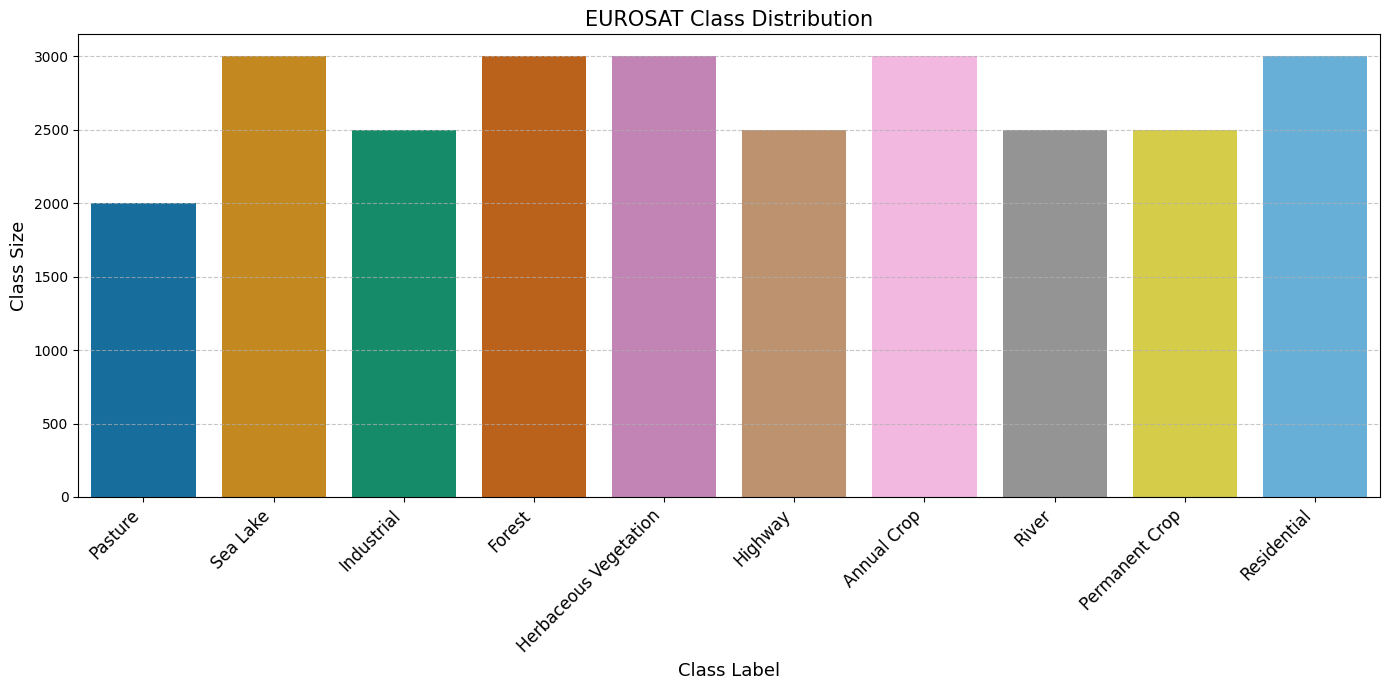

In [11]:
DATASET = "/content/eurosat/2750"
LABELS = os.listdir(DATASET)
counts = {}

def format_label(label):

    return ''.join(' ' + char if char.isupper() else char for char in label).strip()

for label in LABELS:
    formatted_label = format_label(label)
    counts[formatted_label] = len(os.listdir(os.path.join(DATASET, label)))

data = pd.DataFrame({
    'Class Label': list(counts.keys()),
    'Class Size': list(counts.values())
})

colors = sns.color_palette('colorblind', len(data['Class Label']))
plt.figure(figsize=(14, 7))
sns.barplot(x='Class Label', y='Class Size', hue='Class Label', data=data, palette=colors, dodge=False, legend=False)

plt.xticks(rotation=45, fontsize=12, ha='right')
plt.xlabel('Class Label', fontsize=13)
plt.ylabel('Class Size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

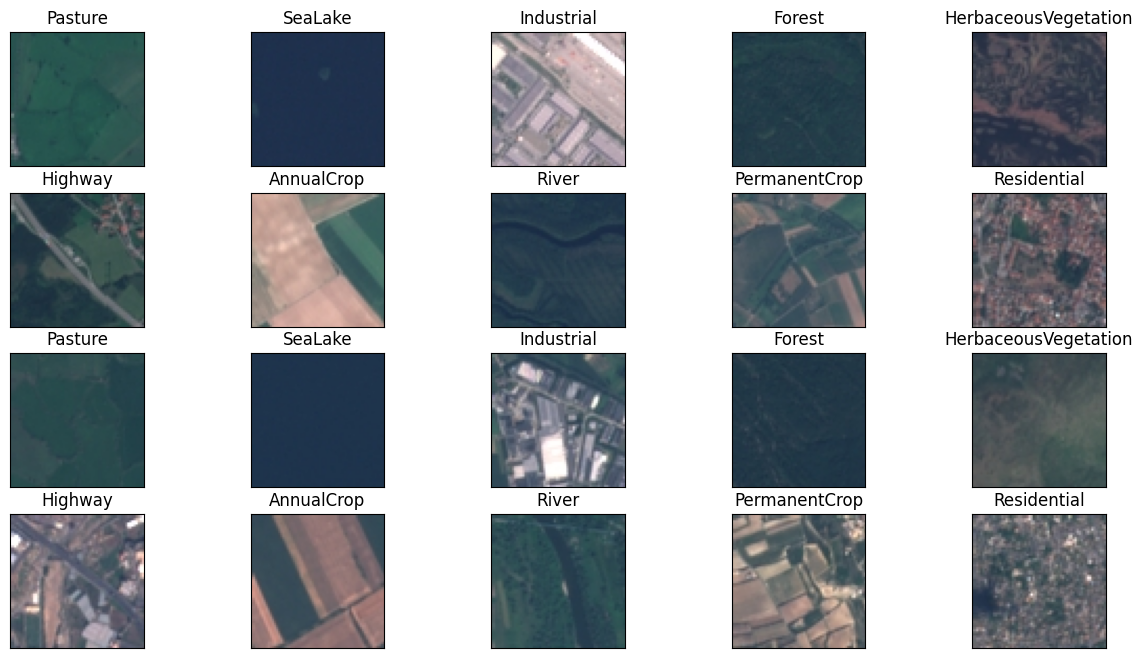

In [ ]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

In [ ]:
print(X.shape)

(27000, 64, 64, 3)


### Split the Dataset into Training and Testing

In [ ]:
# Split the data into training and testing sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


# Split the data
for train_idx, test_idx in split.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

### Apply the Watermark to the Dataset

In [ ]:
def apply_watermark(image_array, text='H', font_size=8, opacity=20):
    # Convert the numpy array to a PIL Image
    image = Image.fromarray(image_array.astype('uint8'), 'RGB')

    # Define the font
    font = ImageFont.load_default()

    # Create a drawing context to measure text
    dummy_image = Image.new("RGB", (1, 1))
    dummy_draw = ImageDraw.Draw(dummy_image)

    # Get the bounding box of the text
    text_width, text_height = dummy_draw.textbbox((0, 0), text, font=font)[2:]

    # Convert image to RGBA to add opacity
    image = image.convert("RGBA")
    overlay = Image.new("RGBA", image.size)
    draw = ImageDraw.Draw(overlay)

    # Randomize position within the boundaries of the image
    max_x = image.size[0] - text_width  # Width of image minus width of text
    max_y = image.size[1] - text_height  # Height of image minus height of text
    random_position = (random.randint(0, max_x), random.randint(0, max_y))

    # Text color with opacity
    text_color = (255, 255, 255, opacity)  # Adjust the opacity here

    # Place the text on the overlay image with partial opacity
    draw.text(random_position, text, font=font, fill=text_color)

    # Combine the overlay with the image
    watermarked_image = Image.alpha_composite(image, overlay)

    # Convert back to RGB to drop the alpha channel
    watermarked_image = watermarked_image.convert("RGB")

    # Convert back to numpy array
    return np.array(watermarked_image)

###Load the Preprocessed Dataset

In [ ]:
class EuroSATDataset(Dataset):
    def __init__(self, X, y, watermark_prob=0.5):
        self.X = X
        self.y = y
        self.watermark_prob = watermark_prob
        self.watermarks = np.random.rand(len(X)) < watermark_prob

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        landscape_label = self.y[idx]
        watermark_label = self.watermarks[idx]

        # Apply watermark if flagged
        if watermark_label:
            image = apply_watermark(image)

        # Convert the image to a tensor and rearrange to 'channels first'
        image = torch.from_numpy(image).float()
        image = image.permute(2, 0, 1)  # Ensuring channels first format

        landscape_label = torch.tensor(landscape_label, dtype=torch.long)
        return image, landscape_label, watermark_label

    def save_dataset_images(dataset, root_dir):
    # Iterate over the dataset with a progress bar
      for i in tqdm(range(len(dataset)), desc="Saving images"):
        image, landscape_label, watermark_label = dataset[i]
        label_name = labels[landscape_label]  # Assuming landscape_label is the index in the labels list

        # Determine the subfolder based on the watermark label
        subfolder = "watermarked" if watermark_label else "non_watermarked"
        file_path = os.path.join(root_dir, label_name, subfolder, f"{i}.png")

        # Save the image
        save_image(image, file_path)

# Create the DataLoader for both training and testing datasets
train_dataset = EuroSATDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = EuroSATDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Set the device to use for training and testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(len(train_loader))

675


In [ ]:
print(len(test_loader))

169


In [ ]:
root_dir = "/content/eurosat/2750/"
labels = ['Forest', 'HerbaceousVegetation', 'AnnualCrop', 'Industrial', 'PermanentCrop', 'SeaLake', 'Residential', 'River', 'Pasture', 'Highway']

# Create a directory for each label and subdirectories for watermarked and non-watermarked
for label in labels:
    os.makedirs(os.path.join(root_dir, label, "watermarked"), exist_ok=True)
    os.makedirs(os.path.join(root_dir, label, "non_watermarked"), exist_ok=True)


## Base Classification Model using ViT

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # Using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # Prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # Add position embedding
        x += self.positions
        return x

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # Fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # Split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # Sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # Sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [ ]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [ ]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [ ]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])


In [ ]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes))

In [ ]:
class ViT(nn.Sequential):
    def __init__(self,
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 64,
                depth: int = 12,
                n_classes: int = 10,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [ ]:
summary(ViT().cuda(), (3, 64, 64), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 4, 4]         590,592
         Rearrange-2              [-1, 16, 768]               0
    PatchEmbedding-3              [-1, 17, 768]               0
         LayerNorm-4              [-1, 17, 768]           1,536
            Linear-5             [-1, 17, 2304]       1,771,776
           Dropout-6            [-1, 8, 17, 17]               0
            Linear-7              [-1, 17, 768]         590,592
MultiHeadAttention-8              [-1, 17, 768]               0
           Dropout-9              [-1, 17, 768]               0
      ResidualAdd-10              [-1, 17, 768]               0
        LayerNorm-11              [-1, 17, 768]           1,536
           Linear-12             [-1, 17, 3072]       2,362,368
             GELU-13             [-1, 17, 3072]               0
          Dropout-14             [-1, 1

In [ ]:
model = ViT()
model=model.cuda()

In [ ]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10


In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
train_losses = []
train_accu = []

def train(epoch):
    print('Epoch : %d'%epoch)

    model.train()
    running_loss=0
    correct=0
    total=0
    for images, landscape_labels, _ in tqdm(train_loader):
        images = images.float().cuda()
        landscape_labels = landscape_labels.float().cuda()
        # Forward pass
        outputs = model(images)
        labels1= np.zeros((32,10))

        for j in range(32):
            i=landscape_labels[j]
            i=int(i.item())
            labels1[j][i]=1
        labels1=torch.from_numpy(labels1)
        labels1=labels1.to(device='cuda')
        loss = criterion(outputs, labels1)


       # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += landscape_labels.size(0)
        correct += predicted.eq(landscape_labels).sum().item()

    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


In [ ]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0
    with torch.no_grad():
        for images, landscape_labels, _ in tqdm(train_loader):
            images = images.float().cuda()
            landscape_labels = landscape_labels.float().cuda()

            # Predict classes using the model
            outputs = model(images)
            t,y=outputs.shape
            labels1= np.zeros((t,10))
            for j in range(t):
                i=landscape_labels[j]
                i=int(i.item())
                labels1[j][i]=1
            labels1=torch.from_numpy(labels1)
            labels1=labels1.to(device='cuda')
            loss= criterion(outputs,labels1)
            running_loss+=loss.item()


           # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += landscape_labels.size(0)
            correct += (predicted == landscape_labels).sum().item()

    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))


### Run Model

In [ ]:
epochs = 70

# Start the time
start_time = time.time()
for epoch in range(1,epochs+1):
    train(epoch)
    test(epoch)
# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print('Training time: {:.2f} seconds'.format(training_time))

Epoch : 1


100%|██████████| 675/675 [00:30<00:00, 22.13it/s]


Train Loss: 1.686 | Accuracy: 37.069


100%|██████████| 675/675 [00:12<00:00, 54.67it/s]


Test Loss: 6.615 | Accuracy: 40.162
Epoch : 2


100%|██████████| 675/675 [00:29<00:00, 22.54it/s]


Train Loss: 1.245 | Accuracy: 54.481


100%|██████████| 675/675 [00:12<00:00, 54.42it/s]


Test Loss: 4.893 | Accuracy: 55.287
Epoch : 3


100%|██████████| 675/675 [00:30<00:00, 22.47it/s]


Train Loss: 1.404 | Accuracy: 49.444


100%|██████████| 675/675 [00:12<00:00, 54.35it/s]


Test Loss: 4.796 | Accuracy: 55.796
Epoch : 4


100%|██████████| 675/675 [00:29<00:00, 22.53it/s]


Train Loss: 1.222 | Accuracy: 56.259


100%|██████████| 675/675 [00:12<00:00, 54.83it/s]


Test Loss: 5.085 | Accuracy: 56.403
Epoch : 5


100%|██████████| 675/675 [00:29<00:00, 22.61it/s]


Train Loss: 1.300 | Accuracy: 53.222


100%|██████████| 675/675 [00:12<00:00, 54.10it/s]


Test Loss: 4.419 | Accuracy: 60.176
Epoch : 6


100%|██████████| 675/675 [00:30<00:00, 22.39it/s]


Train Loss: 1.132 | Accuracy: 58.764


100%|██████████| 675/675 [00:12<00:00, 53.49it/s]


Test Loss: 4.981 | Accuracy: 54.259
Epoch : 7


100%|██████████| 675/675 [00:30<00:00, 22.15it/s]


Train Loss: 1.021 | Accuracy: 62.986


100%|██████████| 675/675 [00:12<00:00, 53.11it/s]


Test Loss: 3.650 | Accuracy: 67.708
Epoch : 8


100%|██████████| 675/675 [00:30<00:00, 22.36it/s]


Train Loss: 1.185 | Accuracy: 57.718


100%|██████████| 675/675 [00:12<00:00, 53.71it/s]


Test Loss: 8.499 | Accuracy: 17.185
Epoch : 9


100%|██████████| 675/675 [00:30<00:00, 22.44it/s]


Train Loss: 1.806 | Accuracy: 29.963


100%|██████████| 675/675 [00:12<00:00, 54.62it/s]


Test Loss: 6.342 | Accuracy: 40.759
Epoch : 10


100%|██████████| 675/675 [00:29<00:00, 22.59it/s]


Train Loss: 1.506 | Accuracy: 45.514


100%|██████████| 675/675 [00:12<00:00, 53.87it/s]


Test Loss: 5.255 | Accuracy: 54.301
Epoch : 11


100%|██████████| 675/675 [00:30<00:00, 22.46it/s]


Train Loss: 1.471 | Accuracy: 47.556


100%|██████████| 675/675 [00:12<00:00, 53.34it/s]


Test Loss: 5.017 | Accuracy: 53.120
Epoch : 12


100%|██████████| 675/675 [00:30<00:00, 22.17it/s]


Train Loss: 1.297 | Accuracy: 53.644


100%|██████████| 675/675 [00:12<00:00, 54.68it/s]


Test Loss: 5.139 | Accuracy: 53.181
Epoch : 13


100%|██████████| 675/675 [00:29<00:00, 22.61it/s]


Train Loss: 1.137 | Accuracy: 59.403


100%|██████████| 675/675 [00:12<00:00, 54.57it/s]


Test Loss: 4.740 | Accuracy: 58.931
Epoch : 14


100%|██████████| 675/675 [00:29<00:00, 22.58it/s]


Train Loss: 1.056 | Accuracy: 62.231


100%|██████████| 675/675 [00:12<00:00, 54.45it/s]


Test Loss: 3.798 | Accuracy: 66.324
Epoch : 15


100%|██████████| 675/675 [00:29<00:00, 22.54it/s]


Train Loss: 1.197 | Accuracy: 58.241


100%|██████████| 675/675 [00:12<00:00, 54.82it/s]


Test Loss: 4.982 | Accuracy: 57.616
Epoch : 16


100%|██████████| 675/675 [00:29<00:00, 22.59it/s]


Train Loss: 1.428 | Accuracy: 49.296


100%|██████████| 675/675 [00:12<00:00, 54.74it/s]


Test Loss: 5.671 | Accuracy: 48.194
Epoch : 17


100%|██████████| 675/675 [00:30<00:00, 22.40it/s]


Train Loss: 1.307 | Accuracy: 53.079


100%|██████████| 675/675 [00:12<00:00, 54.31it/s]


Test Loss: 4.587 | Accuracy: 58.083
Epoch : 18


100%|██████████| 675/675 [00:29<00:00, 22.52it/s]


Train Loss: 1.188 | Accuracy: 57.676


100%|██████████| 675/675 [00:12<00:00, 53.42it/s]


Test Loss: 4.492 | Accuracy: 59.046
Epoch : 19


100%|██████████| 675/675 [00:30<00:00, 22.36it/s]


Train Loss: 1.105 | Accuracy: 60.356


100%|██████████| 675/675 [00:12<00:00, 53.30it/s]


Test Loss: 4.345 | Accuracy: 61.713
Epoch : 20


100%|██████████| 675/675 [00:30<00:00, 22.17it/s]


Train Loss: 1.123 | Accuracy: 60.009


100%|██████████| 675/675 [00:12<00:00, 53.54it/s]


Test Loss: 5.003 | Accuracy: 54.634
Epoch : 21


100%|██████████| 675/675 [00:29<00:00, 22.53it/s]


Train Loss: 1.529 | Accuracy: 45.009


100%|██████████| 675/675 [00:12<00:00, 53.88it/s]


Test Loss: 5.448 | Accuracy: 46.569
Epoch : 22


100%|██████████| 675/675 [00:30<00:00, 22.43it/s]


Train Loss: 1.288 | Accuracy: 53.648


100%|██████████| 675/675 [00:12<00:00, 54.15it/s]


Test Loss: 4.578 | Accuracy: 58.806
Epoch : 23


100%|██████████| 675/675 [00:29<00:00, 22.58it/s]


Train Loss: 1.249 | Accuracy: 55.852


100%|██████████| 675/675 [00:12<00:00, 54.79it/s]


Test Loss: 4.734 | Accuracy: 56.019
Epoch : 24


100%|██████████| 675/675 [00:30<00:00, 22.46it/s]


Train Loss: 1.230 | Accuracy: 55.787


100%|██████████| 675/675 [00:12<00:00, 53.74it/s]


Test Loss: 4.922 | Accuracy: 54.093
Epoch : 25


100%|██████████| 675/675 [00:30<00:00, 22.35it/s]


Train Loss: 1.146 | Accuracy: 59.079


100%|██████████| 675/675 [00:12<00:00, 54.50it/s]


Test Loss: 4.217 | Accuracy: 62.505
Epoch : 26


100%|██████████| 675/675 [00:29<00:00, 22.57it/s]


Train Loss: 1.059 | Accuracy: 62.394


100%|██████████| 675/675 [00:12<00:00, 54.45it/s]


Test Loss: 3.876 | Accuracy: 65.662
Epoch : 27


100%|██████████| 675/675 [00:29<00:00, 22.59it/s]


Train Loss: 1.061 | Accuracy: 62.412


100%|██████████| 675/675 [00:12<00:00, 54.87it/s]


Test Loss: 6.534 | Accuracy: 39.745
Epoch : 28


100%|██████████| 675/675 [00:29<00:00, 22.54it/s]


Train Loss: 1.215 | Accuracy: 56.653


100%|██████████| 675/675 [00:12<00:00, 54.37it/s]


Test Loss: 5.685 | Accuracy: 49.542
Epoch : 29


100%|██████████| 675/675 [00:30<00:00, 22.38it/s]


Train Loss: 1.077 | Accuracy: 61.944


100%|██████████| 675/675 [00:12<00:00, 54.27it/s]


Test Loss: 4.013 | Accuracy: 64.778
Epoch : 30


100%|██████████| 675/675 [00:29<00:00, 22.54it/s]


Train Loss: 1.396 | Accuracy: 51.264


100%|██████████| 675/675 [00:12<00:00, 54.56it/s]


Test Loss: 4.810 | Accuracy: 57.417
Epoch : 31


100%|██████████| 675/675 [00:30<00:00, 22.44it/s]


Train Loss: 1.152 | Accuracy: 58.880


100%|██████████| 675/675 [00:12<00:00, 54.44it/s]


Test Loss: 4.320 | Accuracy: 60.569
Epoch : 32


100%|██████████| 675/675 [00:30<00:00, 22.48it/s]


Train Loss: 1.090 | Accuracy: 61.259


100%|██████████| 675/675 [00:12<00:00, 54.50it/s]


Test Loss: 4.016 | Accuracy: 65.144
Epoch : 33


100%|██████████| 675/675 [00:29<00:00, 22.60it/s]


Train Loss: 1.112 | Accuracy: 60.403


100%|██████████| 675/675 [00:12<00:00, 54.35it/s]


Test Loss: 4.229 | Accuracy: 62.481
Epoch : 34


100%|██████████| 675/675 [00:29<00:00, 22.54it/s]


Train Loss: 1.029 | Accuracy: 63.769


100%|██████████| 675/675 [00:12<00:00, 54.21it/s]


Test Loss: 4.083 | Accuracy: 64.319
Epoch : 35


100%|██████████| 675/675 [00:30<00:00, 22.48it/s]


Train Loss: 1.001 | Accuracy: 64.384


100%|██████████| 675/675 [00:12<00:00, 54.21it/s]


Test Loss: 3.806 | Accuracy: 65.921
Epoch : 36


100%|██████████| 675/675 [00:30<00:00, 22.42it/s]


Train Loss: 0.954 | Accuracy: 66.037


100%|██████████| 675/675 [00:12<00:00, 54.01it/s]


Test Loss: 3.424 | Accuracy: 69.139
Epoch : 37


100%|██████████| 675/675 [00:29<00:00, 22.59it/s]


Train Loss: 0.983 | Accuracy: 64.597


100%|██████████| 675/675 [00:12<00:00, 54.53it/s]


Test Loss: 3.691 | Accuracy: 67.384
Epoch : 38


100%|██████████| 675/675 [00:30<00:00, 22.40it/s]


Train Loss: 0.999 | Accuracy: 64.556


100%|██████████| 675/675 [00:12<00:00, 54.42it/s]


Test Loss: 6.058 | Accuracy: 46.037
Epoch : 39


100%|██████████| 675/675 [00:29<00:00, 22.55it/s]


Train Loss: 1.139 | Accuracy: 59.769


100%|██████████| 675/675 [00:12<00:00, 54.57it/s]


Test Loss: 3.955 | Accuracy: 64.472
Epoch : 40


100%|██████████| 675/675 [00:29<00:00, 22.50it/s]


Train Loss: 1.109 | Accuracy: 60.356


100%|██████████| 675/675 [00:12<00:00, 54.25it/s]


Test Loss: 4.002 | Accuracy: 64.412
Epoch : 41


100%|██████████| 675/675 [00:30<00:00, 22.47it/s]


Train Loss: 1.014 | Accuracy: 63.801


100%|██████████| 675/675 [00:12<00:00, 53.84it/s]


Test Loss: 3.628 | Accuracy: 67.630
Epoch : 42


100%|██████████| 675/675 [00:30<00:00, 22.48it/s]


Train Loss: 0.903 | Accuracy: 67.319


100%|██████████| 675/675 [00:12<00:00, 54.27it/s]


Test Loss: 3.609 | Accuracy: 67.907
Epoch : 43


100%|██████████| 675/675 [00:30<00:00, 22.44it/s]


Train Loss: 0.891 | Accuracy: 68.079


100%|██████████| 675/675 [00:12<00:00, 54.42it/s]


Test Loss: 3.450 | Accuracy: 69.338
Epoch : 44


100%|██████████| 675/675 [00:30<00:00, 22.44it/s]


Train Loss: 0.880 | Accuracy: 68.500


100%|██████████| 675/675 [00:12<00:00, 54.55it/s]


Test Loss: 3.367 | Accuracy: 69.542
Epoch : 45


100%|██████████| 675/675 [00:29<00:00, 22.54it/s]


Train Loss: 0.943 | Accuracy: 66.500


100%|██████████| 675/675 [00:12<00:00, 54.23it/s]


Test Loss: 3.328 | Accuracy: 70.222
Epoch : 46


100%|██████████| 675/675 [00:30<00:00, 22.44it/s]


Train Loss: 0.887 | Accuracy: 68.486


100%|██████████| 675/675 [00:12<00:00, 54.05it/s]


Test Loss: 3.589 | Accuracy: 67.880
Epoch : 47


100%|██████████| 675/675 [00:30<00:00, 22.42it/s]


Train Loss: 1.117 | Accuracy: 60.528


100%|██████████| 675/675 [00:12<00:00, 54.47it/s]


Test Loss: 3.898 | Accuracy: 65.250
Epoch : 48


100%|██████████| 675/675 [00:30<00:00, 22.41it/s]


Train Loss: 0.920 | Accuracy: 67.255


100%|██████████| 675/675 [00:12<00:00, 54.52it/s]


Test Loss: 3.449 | Accuracy: 69.282
Epoch : 49


100%|██████████| 675/675 [00:29<00:00, 22.54it/s]


Train Loss: 0.836 | Accuracy: 70.426


100%|██████████| 675/675 [00:12<00:00, 53.89it/s]


Test Loss: 3.569 | Accuracy: 68.306
Epoch : 50


100%|██████████| 675/675 [00:29<00:00, 22.55it/s]


Train Loss: 0.908 | Accuracy: 67.981


100%|██████████| 675/675 [00:12<00:00, 54.63it/s]


Test Loss: 3.561 | Accuracy: 66.870
Epoch : 51


100%|██████████| 675/675 [00:30<00:00, 22.37it/s]


Train Loss: 0.947 | Accuracy: 66.051


100%|██████████| 675/675 [00:12<00:00, 54.39it/s]


Test Loss: 3.285 | Accuracy: 70.398
Epoch : 52


100%|██████████| 675/675 [00:30<00:00, 22.48it/s]


Train Loss: 0.923 | Accuracy: 67.287


100%|██████████| 675/675 [00:12<00:00, 54.17it/s]


Test Loss: 3.667 | Accuracy: 67.468
Epoch : 53


100%|██████████| 675/675 [00:30<00:00, 22.44it/s]


Train Loss: 0.870 | Accuracy: 68.968


100%|██████████| 675/675 [00:12<00:00, 54.23it/s]


Test Loss: 4.350 | Accuracy: 61.449
Epoch : 54


100%|██████████| 675/675 [00:30<00:00, 22.47it/s]


Train Loss: 0.899 | Accuracy: 67.875


100%|██████████| 675/675 [00:12<00:00, 54.50it/s]


Test Loss: 3.352 | Accuracy: 69.620
Epoch : 55


100%|██████████| 675/675 [00:30<00:00, 22.47it/s]


Train Loss: 0.879 | Accuracy: 68.542


100%|██████████| 675/675 [00:12<00:00, 54.07it/s]


Test Loss: 3.318 | Accuracy: 70.264
Epoch : 56


100%|██████████| 675/675 [00:30<00:00, 22.40it/s]


Train Loss: 0.787 | Accuracy: 71.769


100%|██████████| 675/675 [00:12<00:00, 54.21it/s]


Test Loss: 3.013 | Accuracy: 73.079
Epoch : 57


100%|██████████| 675/675 [00:30<00:00, 22.45it/s]


Train Loss: 0.805 | Accuracy: 71.019


100%|██████████| 675/675 [00:12<00:00, 54.18it/s]


Test Loss: 3.049 | Accuracy: 72.486
Epoch : 58


100%|██████████| 675/675 [00:30<00:00, 22.45it/s]


Train Loss: 0.780 | Accuracy: 71.972


100%|██████████| 675/675 [00:12<00:00, 54.50it/s]


Test Loss: 3.030 | Accuracy: 72.662
Epoch : 59


100%|██████████| 675/675 [00:29<00:00, 22.67it/s]


Train Loss: 0.872 | Accuracy: 68.977


100%|██████████| 675/675 [00:12<00:00, 54.40it/s]


Test Loss: 3.267 | Accuracy: 70.370
Epoch : 60


100%|██████████| 675/675 [00:29<00:00, 22.55it/s]


Train Loss: 1.080 | Accuracy: 62.500


100%|██████████| 675/675 [00:12<00:00, 54.16it/s]


Test Loss: 3.943 | Accuracy: 65.505
Epoch : 61


100%|██████████| 675/675 [00:29<00:00, 22.52it/s]


Train Loss: 1.125 | Accuracy: 60.694


100%|██████████| 675/675 [00:12<00:00, 54.13it/s]


Test Loss: 4.088 | Accuracy: 64.412
Epoch : 62


100%|██████████| 675/675 [00:30<00:00, 22.37it/s]


Train Loss: 1.103 | Accuracy: 61.310


100%|██████████| 675/675 [00:12<00:00, 53.43it/s]


Test Loss: 4.095 | Accuracy: 63.676
Epoch : 63


100%|██████████| 675/675 [00:30<00:00, 22.37it/s]


Train Loss: 1.137 | Accuracy: 59.819


100%|██████████| 675/675 [00:12<00:00, 53.67it/s]


Test Loss: 4.023 | Accuracy: 63.806
Epoch : 64


100%|██████████| 675/675 [00:30<00:00, 22.37it/s]


Train Loss: 1.038 | Accuracy: 63.620


100%|██████████| 675/675 [00:12<00:00, 54.68it/s]


Test Loss: 7.705 | Accuracy: 46.028
Epoch : 65


100%|██████████| 675/675 [00:29<00:00, 22.54it/s]


Train Loss: 1.028 | Accuracy: 63.616


100%|██████████| 675/675 [00:12<00:00, 54.42it/s]


Test Loss: 4.297 | Accuracy: 60.731
Epoch : 66


100%|██████████| 675/675 [00:30<00:00, 22.34it/s]


Train Loss: 1.019 | Accuracy: 64.060


100%|██████████| 675/675 [00:12<00:00, 53.73it/s]


Test Loss: 4.350 | Accuracy: 62.148
Epoch : 67


100%|██████████| 675/675 [00:30<00:00, 22.31it/s]


Train Loss: 0.949 | Accuracy: 66.611


100%|██████████| 675/675 [00:12<00:00, 54.61it/s]


Test Loss: 3.448 | Accuracy: 69.190
Epoch : 68


100%|██████████| 675/675 [00:29<00:00, 22.61it/s]


Train Loss: 0.865 | Accuracy: 69.176


100%|██████████| 675/675 [00:12<00:00, 54.52it/s]


Test Loss: 3.842 | Accuracy: 65.056
Epoch : 69


100%|██████████| 675/675 [00:30<00:00, 22.45it/s]


Train Loss: 0.834 | Accuracy: 70.218


100%|██████████| 675/675 [00:12<00:00, 54.29it/s]


Test Loss: 3.431 | Accuracy: 69.319
Epoch : 70


100%|██████████| 675/675 [00:30<00:00, 22.45it/s]


Train Loss: 0.916 | Accuracy: 67.662


100%|██████████| 675/675 [00:12<00:00, 54.02it/s]

Test Loss: 3.253 | Accuracy: 70.407
Training time: 2975.55 seconds


### Analysis of Model

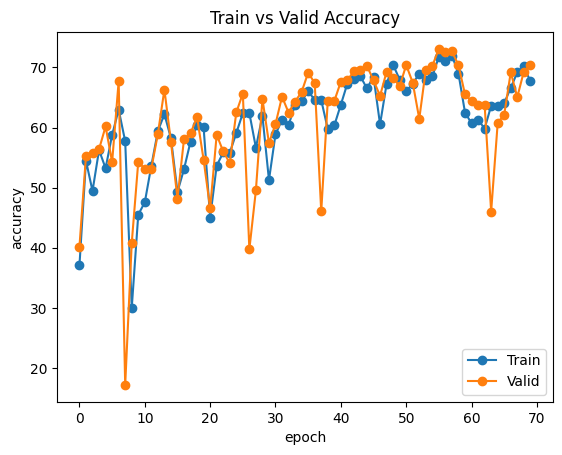

In [ ]:
#Plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

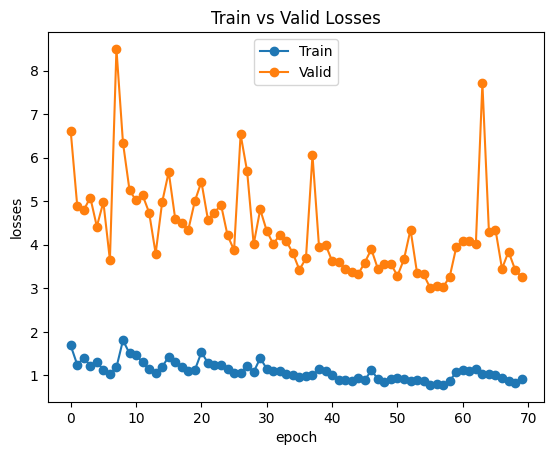

In [ ]:
#Plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [ ]:
# Testing
ttloss = []
ttacc = []
ttf1 = []

T_val = []
P_val = []

with torch.no_grad():
    model.eval()
    for X_val, y_val, _ in tqdm(test_loader):
        X_val = X_val.float().cuda()

        output = model(X_val)

        outputs = torch.max(output, dim=1)[1]
        T_val.extend(y_val.cpu().numpy())
        P_val.extend(outputs.cpu().numpy())
    precision = precision_score(T_val, P_val, average='macro')
    recall = recall_score(T_val, P_val, average='macro')
    res = confusion_matrix(T_val, P_val)
    report = classification_report(T_val, P_val)

    print("Precision: ",precision)
    print("Recall: ",recall)

    print('Confusion matrix:\n',res)
    print('Report:\n',report)

100%|██████████| 169/169 [00:03<00:00, 55.83it/s]

Precision:  0.6991760322117885
Recall:  0.6908166666666667
Confusion matrix:
 [[427   1  14  32   3  18  48  32  19   6]
 [  0 562   6   1   0  16   0   6   6   3]
 [ 18   1 355  14  18   6  49 132   2   5]
 [ 49   1  20 202  37  27  33  55  76   0]
 [  1   0   4  18 447   0   3  27   0   0]
 [  2  12  22  13   0 303  16  12  20   0]
 [ 35   0  49  41  14  10 276  70   5   0]
 [ 19   1  31  25  11   0  25 484   3   1]
 [ 21   7  18 126   6  22   5  21 272   2]
 [  2 118   4   2   0   9   2  15  22 426]]
Report:
               precision    recall  f1-score   support

           0       0.74      0.71      0.73       600
           1       0.80      0.94      0.86       600
           2       0.68      0.59      0.63       600
           3       0.43      0.40      0.41       500
           4       0.83      0.89      0.86       500
           5       0.74      0.76      0.75       400
           6       0.60      0.55      0.58       500
           7       0.57      0.81      0.67      

##Watermark Detection CNN

In [ ]:
class WatermarkDetectorCNN(nn.Module):
    def __init__(self):
        super(WatermarkDetectorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Input size of (3, 64, 64),
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),  # 128 channels, each 8x8 from the last pooling
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2) # Output layer for binary classification
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = self.fc_layers(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WatermarkDetectorCNN().to(device)
# Initialize the CrossEntropyLoss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# Training loop
model.train()
num_epochs = 100
epoch_losses = []
all_labels = []
all_scores = []


for epoch in range(num_epochs):
    batch_losses = []
    for images, _, watermark_labels in tqdm(train_loader):  # Ignore landscape labels
        images = images.to(device)
        watermark_labels = watermark_labels.to(device)  # Ensure labels are long integers
        watermark_labels = watermark_labels.long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, watermark_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        batch_losses.append(loss.item())

    # Calculate and store the average loss for this epoch
    epoch_losses = np.mean(batch_losses)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_losses:.4f}')

100%|██████████| 675/675 [00:07<00:00, 85.42it/s]


Epoch [1/100], Loss: 0.6943


100%|██████████| 675/675 [00:07<00:00, 88.14it/s]


Epoch [2/100], Loss: 0.6932


100%|██████████| 675/675 [00:07<00:00, 87.42it/s]


Epoch [3/100], Loss: 0.6929


100%|██████████| 675/675 [00:07<00:00, 89.59it/s]


Epoch [4/100], Loss: 0.6923


100%|██████████| 675/675 [00:07<00:00, 88.47it/s]


Epoch [5/100], Loss: 0.6901


100%|██████████| 675/675 [00:07<00:00, 88.40it/s]


Epoch [6/100], Loss: 0.6861


100%|██████████| 675/675 [00:07<00:00, 88.91it/s]


Epoch [7/100], Loss: 0.6763


100%|██████████| 675/675 [00:07<00:00, 87.92it/s]


Epoch [8/100], Loss: 0.6576


100%|██████████| 675/675 [00:07<00:00, 88.50it/s]


Epoch [9/100], Loss: 0.6351


100%|██████████| 675/675 [00:07<00:00, 87.88it/s]


Epoch [10/100], Loss: 0.6077


100%|██████████| 675/675 [00:07<00:00, 86.32it/s]


Epoch [11/100], Loss: 0.5758


100%|██████████| 675/675 [00:07<00:00, 87.20it/s]


Epoch [12/100], Loss: 0.5452


100%|██████████| 675/675 [00:07<00:00, 88.26it/s]


Epoch [13/100], Loss: 0.5132


100%|██████████| 675/675 [00:07<00:00, 88.46it/s]


Epoch [14/100], Loss: 0.4786


100%|██████████| 675/675 [00:07<00:00, 88.59it/s]


Epoch [15/100], Loss: 0.4425


100%|██████████| 675/675 [00:07<00:00, 88.75it/s]


Epoch [16/100], Loss: 0.4118


100%|██████████| 675/675 [00:07<00:00, 87.12it/s]


Epoch [17/100], Loss: 0.3766


100%|██████████| 675/675 [00:07<00:00, 87.91it/s]


Epoch [18/100], Loss: 0.3394


100%|██████████| 675/675 [00:07<00:00, 87.23it/s]


Epoch [19/100], Loss: 0.3022


100%|██████████| 675/675 [00:07<00:00, 86.90it/s]


Epoch [20/100], Loss: 0.2542


100%|██████████| 675/675 [00:07<00:00, 87.72it/s]


Epoch [21/100], Loss: 0.2062


100%|██████████| 675/675 [00:07<00:00, 87.75it/s]


Epoch [22/100], Loss: 0.1670


100%|██████████| 675/675 [00:07<00:00, 85.37it/s]


Epoch [23/100], Loss: 0.1362


100%|██████████| 675/675 [00:07<00:00, 87.71it/s]


Epoch [24/100], Loss: 0.1131


100%|██████████| 675/675 [00:07<00:00, 87.59it/s]


Epoch [25/100], Loss: 0.0930


100%|██████████| 675/675 [00:07<00:00, 90.22it/s]


Epoch [26/100], Loss: 0.0836


100%|██████████| 675/675 [00:07<00:00, 88.33it/s]


Epoch [27/100], Loss: 0.0756


100%|██████████| 675/675 [00:07<00:00, 88.40it/s]


Epoch [28/100], Loss: 0.0668


100%|██████████| 675/675 [00:07<00:00, 89.22it/s]


Epoch [29/100], Loss: 0.0601


100%|██████████| 675/675 [00:07<00:00, 88.87it/s]


Epoch [30/100], Loss: 0.0510


100%|██████████| 675/675 [00:07<00:00, 88.87it/s]


Epoch [31/100], Loss: 0.0474


100%|██████████| 675/675 [00:07<00:00, 89.37it/s]


Epoch [32/100], Loss: 0.0455


100%|██████████| 675/675 [00:07<00:00, 87.58it/s]


Epoch [33/100], Loss: 0.0427


100%|██████████| 675/675 [00:07<00:00, 89.06it/s]


Epoch [34/100], Loss: 0.0419


100%|██████████| 675/675 [00:07<00:00, 89.32it/s]


Epoch [35/100], Loss: 0.0373


100%|██████████| 675/675 [00:07<00:00, 89.01it/s]


Epoch [36/100], Loss: 0.0326


100%|██████████| 675/675 [00:07<00:00, 89.45it/s]


Epoch [37/100], Loss: 0.0351


100%|██████████| 675/675 [00:07<00:00, 89.48it/s]


Epoch [38/100], Loss: 0.0321


100%|██████████| 675/675 [00:07<00:00, 88.56it/s]


Epoch [39/100], Loss: 0.0275


100%|██████████| 675/675 [00:07<00:00, 89.40it/s]


Epoch [40/100], Loss: 0.0287


100%|██████████| 675/675 [00:07<00:00, 88.87it/s]


Epoch [41/100], Loss: 0.0285


100%|██████████| 675/675 [00:07<00:00, 88.93it/s]


Epoch [42/100], Loss: 0.0249


100%|██████████| 675/675 [00:07<00:00, 88.62it/s]


Epoch [43/100], Loss: 0.0211


100%|██████████| 675/675 [00:07<00:00, 89.56it/s]


Epoch [44/100], Loss: 0.0217


100%|██████████| 675/675 [00:07<00:00, 89.61it/s]


Epoch [45/100], Loss: 0.0239


100%|██████████| 675/675 [00:07<00:00, 89.05it/s]


Epoch [46/100], Loss: 0.0228


100%|██████████| 675/675 [00:07<00:00, 88.40it/s]


Epoch [47/100], Loss: 0.0216


100%|██████████| 675/675 [00:07<00:00, 87.28it/s]


Epoch [48/100], Loss: 0.0199


100%|██████████| 675/675 [00:07<00:00, 88.87it/s]


Epoch [49/100], Loss: 0.0220


100%|██████████| 675/675 [00:07<00:00, 89.45it/s]


Epoch [50/100], Loss: 0.0200


100%|██████████| 675/675 [00:07<00:00, 86.46it/s]


Epoch [51/100], Loss: 0.0193


100%|██████████| 675/675 [00:07<00:00, 87.05it/s]


Epoch [52/100], Loss: 0.0194


100%|██████████| 675/675 [00:07<00:00, 89.48it/s]


Epoch [53/100], Loss: 0.0192


100%|██████████| 675/675 [00:07<00:00, 90.24it/s]


Epoch [54/100], Loss: 0.0164


100%|██████████| 675/675 [00:07<00:00, 88.53it/s]


Epoch [55/100], Loss: 0.0179


100%|██████████| 675/675 [00:07<00:00, 89.51it/s]


Epoch [56/100], Loss: 0.0188


100%|██████████| 675/675 [00:07<00:00, 88.85it/s]


Epoch [57/100], Loss: 0.0163


100%|██████████| 675/675 [00:07<00:00, 88.67it/s]


Epoch [58/100], Loss: 0.0164


100%|██████████| 675/675 [00:07<00:00, 88.73it/s]


Epoch [59/100], Loss: 0.0186


100%|██████████| 675/675 [00:07<00:00, 86.19it/s]


Epoch [60/100], Loss: 0.0164


100%|██████████| 675/675 [00:07<00:00, 86.63it/s]


Epoch [61/100], Loss: 0.0179


100%|██████████| 675/675 [00:07<00:00, 88.76it/s]


Epoch [62/100], Loss: 0.0174


100%|██████████| 675/675 [00:07<00:00, 86.77it/s]


Epoch [63/100], Loss: 0.0182


100%|██████████| 675/675 [00:07<00:00, 88.32it/s]


Epoch [64/100], Loss: 0.0135


100%|██████████| 675/675 [00:07<00:00, 89.06it/s]


Epoch [65/100], Loss: 0.0187


100%|██████████| 675/675 [00:07<00:00, 88.73it/s]


Epoch [66/100], Loss: 0.0155


100%|██████████| 675/675 [00:07<00:00, 88.58it/s]


Epoch [67/100], Loss: 0.0144


100%|██████████| 675/675 [00:07<00:00, 88.65it/s]


Epoch [68/100], Loss: 0.0129


100%|██████████| 675/675 [00:07<00:00, 88.63it/s]


Epoch [69/100], Loss: 0.0146


100%|██████████| 675/675 [00:07<00:00, 89.28it/s]


Epoch [70/100], Loss: 0.0133


100%|██████████| 675/675 [00:07<00:00, 89.07it/s]


Epoch [71/100], Loss: 0.0124


100%|██████████| 675/675 [00:07<00:00, 87.08it/s]


Epoch [72/100], Loss: 0.0133


100%|██████████| 675/675 [00:07<00:00, 88.81it/s]


Epoch [73/100], Loss: 0.0136


100%|██████████| 675/675 [00:07<00:00, 89.59it/s]


Epoch [74/100], Loss: 0.0193


100%|██████████| 675/675 [00:07<00:00, 89.01it/s]


Epoch [75/100], Loss: 0.0178


100%|██████████| 675/675 [00:07<00:00, 87.86it/s]


Epoch [76/100], Loss: 0.0133


100%|██████████| 675/675 [00:07<00:00, 88.69it/s]


Epoch [77/100], Loss: 0.0162


100%|██████████| 675/675 [00:07<00:00, 88.38it/s]


Epoch [78/100], Loss: 0.0120


100%|██████████| 675/675 [00:07<00:00, 87.08it/s]


Epoch [79/100], Loss: 0.0131


100%|██████████| 675/675 [00:07<00:00, 87.05it/s]


Epoch [80/100], Loss: 0.0128


100%|██████████| 675/675 [00:07<00:00, 89.37it/s]


Epoch [81/100], Loss: 0.0102


100%|██████████| 675/675 [00:07<00:00, 88.75it/s]


Epoch [82/100], Loss: 0.0147


100%|██████████| 675/675 [00:07<00:00, 89.20it/s]


Epoch [83/100], Loss: 0.0098


100%|██████████| 675/675 [00:07<00:00, 88.70it/s]


Epoch [84/100], Loss: 0.0158


100%|██████████| 675/675 [00:07<00:00, 88.67it/s]


Epoch [85/100], Loss: 0.0133


100%|██████████| 675/675 [00:07<00:00, 88.70it/s]


Epoch [86/100], Loss: 0.0134


100%|██████████| 675/675 [00:07<00:00, 88.16it/s]


Epoch [87/100], Loss: 0.0127


100%|██████████| 675/675 [00:07<00:00, 88.26it/s]


Epoch [88/100], Loss: 0.0114


100%|██████████| 675/675 [00:07<00:00, 89.83it/s]


Epoch [89/100], Loss: 0.0153


100%|██████████| 675/675 [00:07<00:00, 89.64it/s]


Epoch [90/100], Loss: 0.0150


100%|██████████| 675/675 [00:07<00:00, 88.43it/s]


Epoch [91/100], Loss: 0.0115


100%|██████████| 675/675 [00:07<00:00, 88.03it/s]


Epoch [92/100], Loss: 0.0128


100%|██████████| 675/675 [00:07<00:00, 89.34it/s]


Epoch [93/100], Loss: 0.0103


100%|██████████| 675/675 [00:07<00:00, 88.06it/s]


Epoch [94/100], Loss: 0.0157


100%|██████████| 675/675 [00:07<00:00, 88.80it/s]


Epoch [95/100], Loss: 0.0110


100%|██████████| 675/675 [00:07<00:00, 90.01it/s]


Epoch [96/100], Loss: 0.0108


100%|██████████| 675/675 [00:07<00:00, 87.60it/s]


Epoch [97/100], Loss: 0.0132


100%|██████████| 675/675 [00:07<00:00, 89.10it/s]


Epoch [98/100], Loss: 0.0132


100%|██████████| 675/675 [00:07<00:00, 89.30it/s]


Epoch [99/100], Loss: 0.0108


100%|██████████| 675/675 [00:07<00:00, 88.57it/s]

Epoch [100/100], Loss: 0.0086


### Analysis of Watermark Detection Model

In [ ]:
_, predicted = torch.max(outputs, 1)  # Get the predicted classes
accuracy = (predicted == watermark_labels).float().mean()  # Calculate accuracy


100%|██████████| 675/675 [00:05<00:00, 114.98it/s]


Accuracy: 0.9994444444444445
Precision: 0.9991538172245205
Recall: 0.9997177798682972
F1 Score: 0.999435718988056
AUC Score: 0.9994486802714322


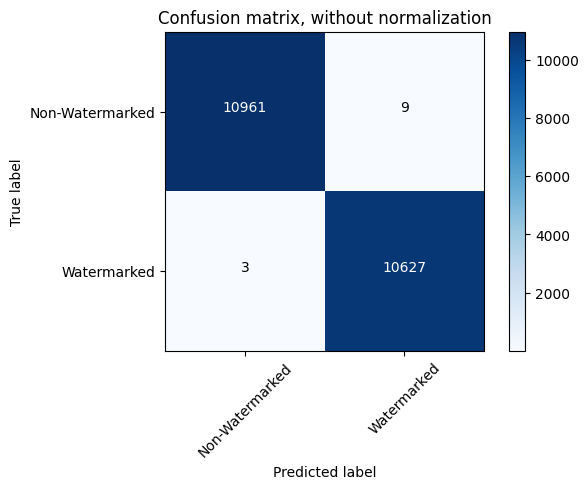

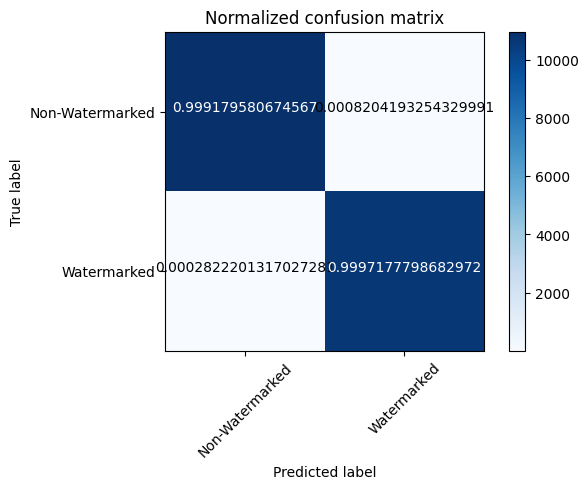

In [ ]:
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, _, watermark_labels in tqdm(train_loader):
        images = images.to(device)
        watermark_labels = watermark_labels.to(device)
        watermark_labels = watermark_labels.long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(watermark_labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC Score:", auc)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(all_labels, all_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non-Watermarked', 'Watermarked'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non-Watermarked', 'Watermarked'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Save Watermarked Images

In [ ]:
def save_dataset_images(dataset, root_dir):
    labels = ['Forest', 'HerbaceousVegetation', 'AnnualCrop', 'Industrial', 'PermanentCrop', 'SeaLake', 'Residential', 'River', 'Pasture', 'Highway']

    # Ensure directory structure
    for label in labels:
        os.makedirs(os.path.join(root_dir, label, "watermarked"), exist_ok=True)
        os.makedirs(os.path.join(root_dir, label, "non_watermarked"), exist_ok=True)

    pbar = tqdm(enumerate(dataset), total=len(dataset), desc="Saving images")

    for i, (image_tensor, landscape_label, watermark_label) in pbar:
        label_name = labels[landscape_label]
        subfolder = "watermarked" if watermark_label else "non_watermarked"
        jpeg_path = os.path.join(root_dir, label_name, subfolder, f"{i}.jpeg")

        # Convert the PyTorch tensor to a NumPy array
        image_np = image_tensor.numpy()

        # Normalize and save the image as JPEG
        rgb_image = np.transpose(image_np, (1, 2, 0))  # Change to HxWxC
        rgb_image = (rgb_image * 255).astype(np.uint8)
        rgb_image = rgb_image[..., ::-1]
        im = Image.fromarray(rgb_image)
        im.save(jpeg_path)

root_dir = "/content/eurosat/2750"  t
save_dataset_images(train_dataset, root_dir)

Saving images: 100%|██████████| 21600/21600 [00:13<00:00, 1601.72it/s]


## GAN Image Model

### Call Dataset from Watermarked and Non Watermarked

In [ ]:
#Create folder for generated images
gen_dir_path = '/content/eurosat/2750/generated'
os.makedirs(gen_dir_path, exist_ok=True)

In [ ]:
class Watermarked_Dataset(Dataset):
    def __init__(self, root_dir, categories, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.files = []
        self.labels = []

        for category in categories:
          # Paths to watermarked and non_watermarked subdirectories within each category
          watermarked_dir = os.path.join(root_dir, category, 'watermarked')
          non_watermarked_dir = os.path.join(root_dir, category, 'non_watermarked')

          # Check for watermarked directory and add images
          if os.path.exists(watermarked_dir):
              for file in os.listdir(watermarked_dir):
                  if file.endswith('.jpeg'):
                      file_path = os.path.join(watermarked_dir, file)
                      self.files.append(file_path)
                      self.labels.append(1)  # 1 for watermarked

          # Check for non_watermarked directory and add images
          if os.path.exists(non_watermarked_dir):
              for file in os.listdir(non_watermarked_dir):
                  if file.endswith('.jpeg'):
                      file_path = os.path.join(non_watermarked_dir, file)
                      self.files.append(file_path)
                      self.labels.append(0)  # 0 for non_watermarked

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]

        # Load image with PIL
        image = Image.open(img_path)

        # Convert the image to a PyTorch tensor
        image = transforms.ToTensor()(image)

        # Normalize the image if a transform is provided
        if self.transform:
            image = self.transform(image)  # Apply the transform

        return image, label

# Define the normalization transform
transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

category_names = ['AnnualCrop', 'HerbaceousVegetation', 'Forest', 'Pasture', 'Industrial',
                  'SeaLake', 'PermanentCrop', 'Residential', 'River', 'Highway']

In [ ]:
root_dir = '/content/eurosat/2750/'
watermarked_dataset = Watermarked_Dataset(root_dir, category_names, transform=transform)
train_loader = DataLoader(watermarked_dataset, batch_size=32, shuffle=True)


In [ ]:
print(f'Total images: {len(watermarked_dataset)}')
print(f'Total images in Batch: {len(train_loader)}')

In [ ]:
# Get the first image and label from the dataset
image, label = watermarked_dataset[0]
# Print the shape; it should be in (C, H, W)
print(image.shape)
# Check what the dataset returns directly
sample_image, sample_label = watermarked_dataset[0]
print(sample_image.shape)  # This should print (3, 64, 64)
# Check the first batch from the DataLoader
for images, labels in train_loader:
    print(images.shape)
    print(type(images))
    break


torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([32, 3, 64, 64])
<class 'torch.Tensor'>


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16

In [ ]:
image_shape = (3, 64, 64)
image_dim = int(np.prod(image_shape))
latent_dim = 100

In [ ]:
num_class = len(train_loader.dataset.labels)
print('Training samples: ', len(train_loader)*batch_size)
print('number of batches: ', len(train_loader))

Training samples:  10800
number of batches:  675


In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    if images.max() > 1.0 or images.min() < 0.0:
            images = (images - images.min()) / (images.max() - images.min())
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

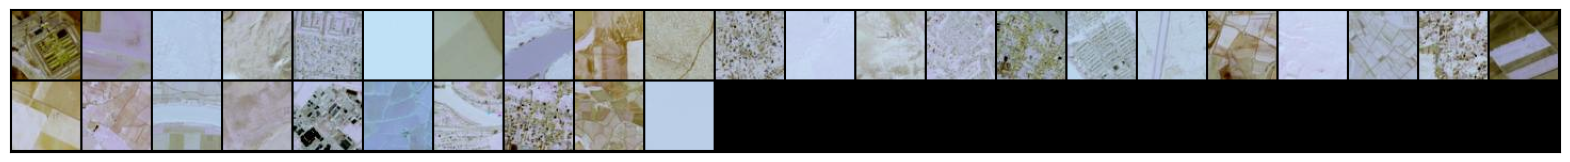

In [ ]:
show_batch(train_loader)

### Load GAN Model

In [ ]:
# Generator Model Class Definition
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Block 1:input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # Block 2: input is (64 * 8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # Block 3: input is (64 * 4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # Block 4: input is (64 * 2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Block 5: input is (64) x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: output is (3) x 64 x 64
            )
    def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
# Discriminator Model Class Definition
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Block 1: input is (3) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 2: input is (64) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 3: input is (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 4: input is (64*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 5: input is (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
            # Output: 1
            )
    def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
generator = Generator().to(device)
generator.apply(weights_init_normal)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init_normal)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
    (13): Flatten(start_dim=1, end_d

In [ ]:
summary(generator, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
summary(discriminator, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
          Flatten-14                   

In [ ]:
adversarial_loss = nn.BCELoss()

In [ ]:
def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    #print(gen_loss)
    return gen_loss

In [ ]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [ ]:
fixed_noise = torch.randn(128, latent_dim, 1, 1, device=device)
real_label = 1
fake_label = 0

In [ ]:
learning_rate = 0.0002
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

### Run GAN Model

In [ ]:
num_epochs = 300
D_loss_plot, G_loss_plot = [], []

for epoch in range(1, num_epochs+1):
    D_loss_list, G_loss_list = [], []

    # Adjust enumeration to unpack all items from the loader
    for index, (real_images, _) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)

        # Prepare targets for the discriminator
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))  # Real images
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))  # Fake images

        # Discriminator loss on real images
        D_real_loss = discriminator_loss(discriminator(real_images), real_target)
        D_real_loss.backward()

        # Generate fake images
        noise_vector = torch.randn(real_images.size(0), latent_dim, 1, 1, device=device)
        generated_image = generator(noise_vector)

        # Discriminator loss on fake images
        output = discriminator(generated_image.detach())
        D_fake_loss = discriminator_loss(output, fake_target)
        D_fake_loss.backward()

        D_total_loss = D_real_loss + D_fake_loss
        D_loss_list.append(D_total_loss.item())

        D_optimizer.step()

        # Generator training
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator(generated_image), real_target)
        G_loss.backward()
        G_optimizer.step()
        G_loss_list.append(G_loss.item())

    # Logging
    print(f'Epoch: [{epoch}/{num_epochs}]: D_loss: {np.mean(D_loss_list):.3f}, G_loss: {np.mean(G_loss_list):.3f}')
    D_loss_plot.append(np.mean(D_loss_list))
    G_loss_plot.append(np.mean(G_loss_list))

    # Saving generated images and model at the last epoch
    if epoch == 300:
        for i in range(generated_image.shape[0]):
            save_image(generated_image[i], f'/content/eurosat/2750/generated/{i}.png', normalize=True)
        torch.save(generator.state_dict(), f'/content/eurosat/2750/generator_epoch_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'/content/eurosat/2750/discriminator_epoch_{epoch}.pth')

Epoch: [1/300]: D_loss: 0.566, G_loss: 7.443
Epoch: [2/300]: D_loss: 0.798, G_loss: 3.538
Epoch: [3/300]: D_loss: 0.898, G_loss: 3.222
Epoch: [4/300]: D_loss: 0.734, G_loss: 3.543
Epoch: [5/300]: D_loss: 0.652, G_loss: 3.781
Epoch: [6/300]: D_loss: 0.592, G_loss: 3.942
Epoch: [7/300]: D_loss: 0.583, G_loss: 3.951
Epoch: [8/300]: D_loss: 0.545, G_loss: 4.001
Epoch: [9/300]: D_loss: 0.546, G_loss: 4.121
Epoch: [10/300]: D_loss: 0.511, G_loss: 4.215
Epoch: [11/300]: D_loss: 0.509, G_loss: 4.266
Epoch: [12/300]: D_loss: 0.467, G_loss: 4.484
Epoch: [13/300]: D_loss: 0.391, G_loss: 4.479
Epoch: [14/300]: D_loss: 0.435, G_loss: 4.731
Epoch: [15/300]: D_loss: 0.379, G_loss: 4.809
Epoch: [16/300]: D_loss: 0.374, G_loss: 4.968
Epoch: [17/300]: D_loss: 0.321, G_loss: 5.039
Epoch: [18/300]: D_loss: 0.359, G_loss: 5.260
Epoch: [19/300]: D_loss: 0.338, G_loss: 5.178
Epoch: [20/300]: D_loss: 0.287, G_loss: 5.243
Epoch: [21/300]: D_loss: 0.309, G_loss: 5.246
Epoch: [22/300]: D_loss: 0.298, G_loss: 5.3

## Save Final Results

## Save Generated Images

In [ ]:
def zip_all_png(directory_path, zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'w') as zipf:
        for foldername, subfolders, filenames in os.walk(directory_path):
            for filename in filenames:
                # Check if the file is a PNG
                if filename.endswith('.png'):
                    file_path = os.path.join(foldername, filename)
                    zipf.write(file_path, arcname=filename)

directory_to_zip = '/content/eurosat/2750/generated'
zip_output_path = '/content/generated_images.zip'
zip_all_png(directory_to_zip, zip_output_path)

### Save All Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def zip_all_files(directory_path, zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'w') as zipf:
        for foldername, subfolders, filenames in os.walk(directory_path):
            for filename in filenames:
                file_path = os.path.join(foldername, filename)
                arcname = os.path.relpath(file_path, directory_path)
                zipf.write(file_path, arcname=arcname)

directory_to_zip = '/content/eurosat/2750'
zip_output_path = '/content/drive/MyDrive/Master_Thesis/fulldataset.zip'
zip_all_files(directory_to_zip, zip_output_path)